In [23]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torchxrayvision as xrv
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Dataset class
class LiverUltrasoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        label_map = {'Normal': 0, 'Benign': 1, 'Malignant': 2}
        for label in label_map:
            img_dir = os.path.join(root_dir, label, label, 'image')
            if os.path.isdir(img_dir):
                for fname in os.listdir(img_dir):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append((os.path.join(img_dir, fname), label_map[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transform (simulate HU-style range)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2048)
])

[Epoch 1] Loss: 20.5593 | Accuracy: 0.5238
[Epoch 2] Loss: 20.1920 | Accuracy: 0.5986
[Epoch 3] Loss: 19.9090 | Accuracy: 0.6344
[Epoch 4] Loss: 19.5712 | Accuracy: 0.6616
[Epoch 5] Loss: 19.2533 | Accuracy: 0.6429


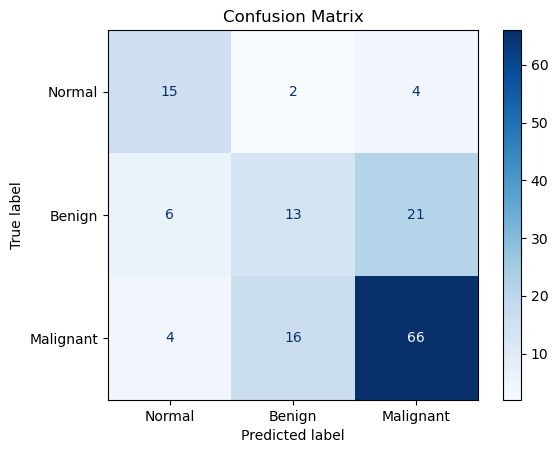


Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.71      0.65        21
      Benign       0.42      0.33      0.37        40
   Malignant       0.73      0.77      0.75        86

    accuracy                           0.64       147
   macro avg       0.58      0.60      0.59       147
weighted avg       0.62      0.64      0.63       147



In [24]:
# Load dataset
dataset = LiverUltrasoundDataset("./7272660", transform=transform)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Compute class weights for imbalance
y_all = [label for _, label in dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_all), y=y_all)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load RadImageNet DenseNet
base_model = xrv.models.DenseNet(weights="densenet121-res224-all")

# Freeze all layers first
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze last block and classifier
for name, param in base_model.named_parameters():
    if "denseblock4" in name or "classifier" in name:
        param.requires_grad = True

# Replace classifier head
in_features = base_model.classifier.in_features
base_model.classifier = nn.Linear(in_features, 3)

# Disable RadImageNet hooks
base_model.op_threshs = None
base_model.apply_sigmoid = False

# Training function
def train_model(model, train_loader, val_loader, criterion, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total_samples = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (y_pred.argmax(1) == y).sum().item()
            total_samples += y.size(0)

        acc = correct / total_samples
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")

# Evaluation function
def evaluate_model(model, dataloader, class_names=["Normal", "Benign", "Malignant"]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Prepare criterion with class weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Train and evaluate
train_model(base_model, train_loader, val_loader, criterion, epochs=5)
evaluate_model(base_model, val_loader)